IMPORT LIBRARY

In [212]:
import numpy as np
from skimage import io
import scipy.ndimage as ndi
from PIL import Image,ImageEnhance
from skimage.transform import resize

REFFLECTION REMOVAL WITH RELATIVE SMOOTHNESS FUNCTION (LB14)

In [213]:
def SIRR(I,lamb,first_iter_max = 5,second_max_iteration = 100):
    if I.max() > 1:
        I = I / 255
    S = np.shape(I)
    size_wh = S[0:2]
    dim_repmat = (S[2], 1,1)
    filter1 = np.array([[1, -1]])
    filter2 = filter1.T
    filter3 = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])

    nor1 = np.tile(np.abs(np.fft.fftn(filter3, size_wh)).T, dim_repmat).T**2 * np.fft.fft2(I,axes = (0,1))
    den1 = np.tile(np.abs(np.fft.fftn(filter3,size_wh).T)**2,dim_repmat).T 
    den2 = np.tile(np.abs(np.fft.fftn(filter1,size_wh).T)**2 + np.abs(np.fft.fftn(filter2,size_wh).T)**2,dim_repmat).T

    low_b = np.zeros_like(I)
    g1 = np.zeros_like(I)
    g2 = np.zeros_like(I)
    up_b = I
    eps = 1e-16
    beta = 20
    LB = I
    iter_max = first_iter_max
    
    while iter_max:
        iter_max-=1
        g1[:,:,0] = ndi.convolve(LB[:,:,0], filter1,mode='wrap')
        g1[:,:,1] = ndi.convolve(LB[:,:,1], filter1,mode='wrap')
        g1[:,:,2] = ndi.convolve(LB[:,:,2], filter1,mode='wrap')
        mask = np.tile(np.sum(np.abs(g1), axis=2).T < 1/beta, dim_repmat).T
        g1[mask] = 0
    
        g2[:,:,0] = ndi.convolve(LB[:,:,0], filter2,mode='wrap')
        g2[:,:,1] = ndi.convolve(LB[:,:,1], filter2,mode='wrap')
        g2[:,:,2] = ndi.convolve(LB[:,:,2], filter2,mode='wrap')
        mask_2 = np.tile(np.sum(np.abs(g2), axis=2).T < 1/beta, dim_repmat).T
        g2[mask_2] = 0

        nor2 = np.concatenate((np.concatenate([[g1[:, -1, :] - g1[:, 0, :]]], axis=2).reshape(-1, 1,3),-np.diff(g1,axis=1)),axis=1) +\
            np.concatenate((np.concatenate([[g2[-1,:,:] - g2[0,:,:]]], axis=2).reshape(1, -1,3),-np.diff(g2, axis=0)),axis=0)
    
        nor = lamb * nor1 + beta * np.fft.fft2(nor2,axes = (0,1))
    
        den = lamb * den1 + beta * den2 + eps

        LB = np.real(np.fft.ifft2(nor/den, axes = (0,1)))

        for i in range(dim_repmat[0]):
            
            max_iteration = second_max_iteration
            LB_t = LB[:,:,i]
            threshold = 1/np.size(LB_t)
            while max_iteration:
                max_iteration-=1
                dt_nor = np.sum(LB_t[LB_t < low_b[:, :, i]])

                dt = -2 * (dt_nor + np.sum(LB_t[LB_t > up_b[:, :, i]])) / np.size(LB_t)
      
                LB_t = LB_t + dt
                if np.abs(dt) < threshold:
                    break
            LB[:,:,i] = LB_t

        LB[LB < low_b] = low_b[LB < low_b]
        LB[LB > up_b] = up_b[LB > up_b]


        beta *= 2
    LR = I - LB

    return LB,LR


BASE LB14

In [214]:
I = io.imread('8.jpg') 

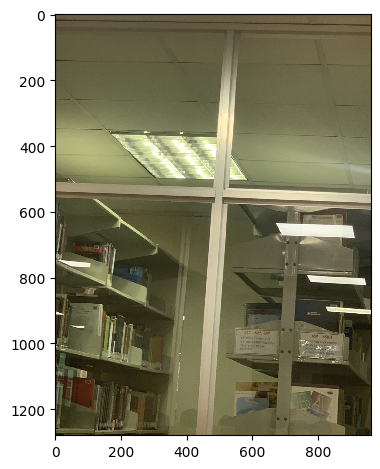

In [215]:
io.imshow(I)

In [216]:
LB, LR  = SIRR(I,10)

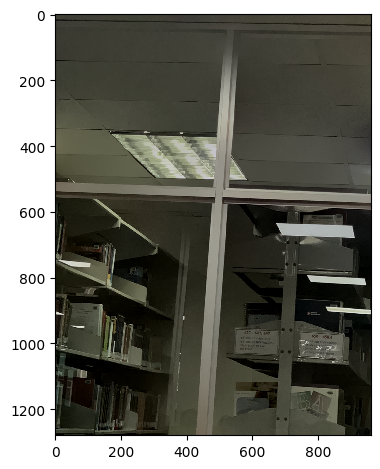

In [217]:
io.imshow(LB)

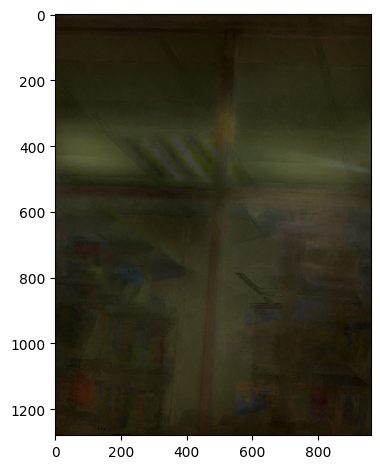

In [218]:
io.imshow(LR)

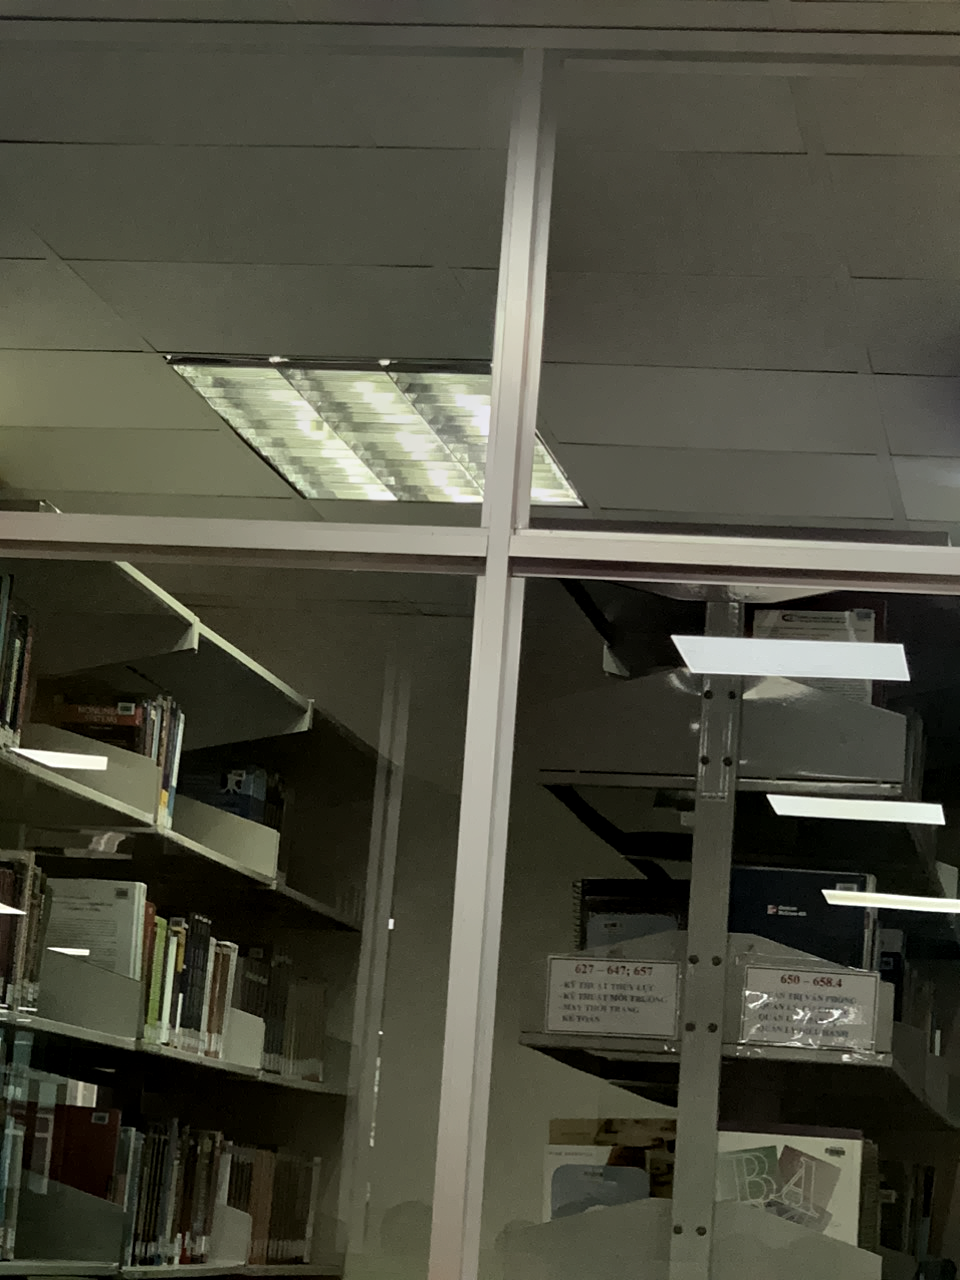

In [219]:
img = Image.fromarray(np.uint8(LB*255))

# Enhance Brightness
curr_bri = ImageEnhance.Brightness(img)
new_bri = 1.2
  
# Brightness enhanced by a factor of 2.5
img_brightened = curr_bri.enhance(new_bri)
  
# shows updated image in image viewer
img_brightened

SPEED UP

1. DOWNSIZE INPUT IMAGE THEN USE FUNCTION TO GET REFLECTION LAYER (LR). AFTER THAT, UPSIZE LR THEN SUBTRACTED IT BY INPUT IMAGE

In [220]:
I_downsize = resize(I , (I.shape[0] / 2, I.shape[1] / 2),anti_aliasing=True)  

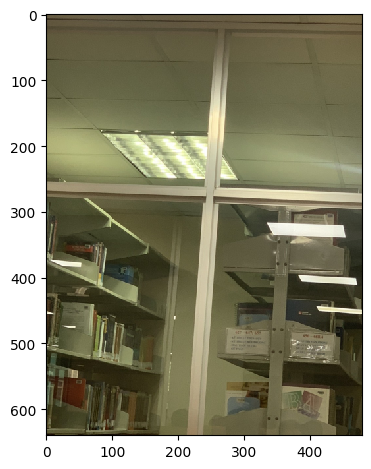

In [221]:
io.imshow(I_downsize)

In [222]:
LB_downsize,LR_downsize = SIRR(I_downsize,10)

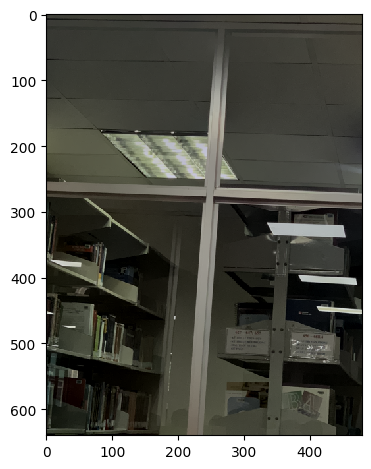

In [223]:
io.imshow(LB_downsize)

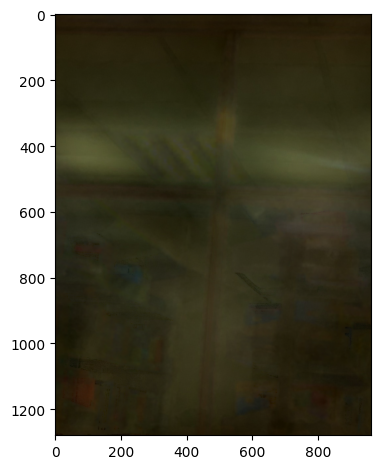

In [224]:
LR_upsize = resize(LR_downsize , (I.shape[0] , I.shape[1] ),anti_aliasing=True)  
LB_upsize = abs(I/255 - LR_upsize )
io.imshow(LR_upsize)

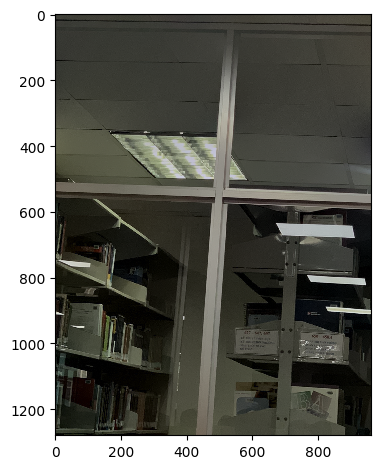

In [225]:
io.imshow(LB_upsize)

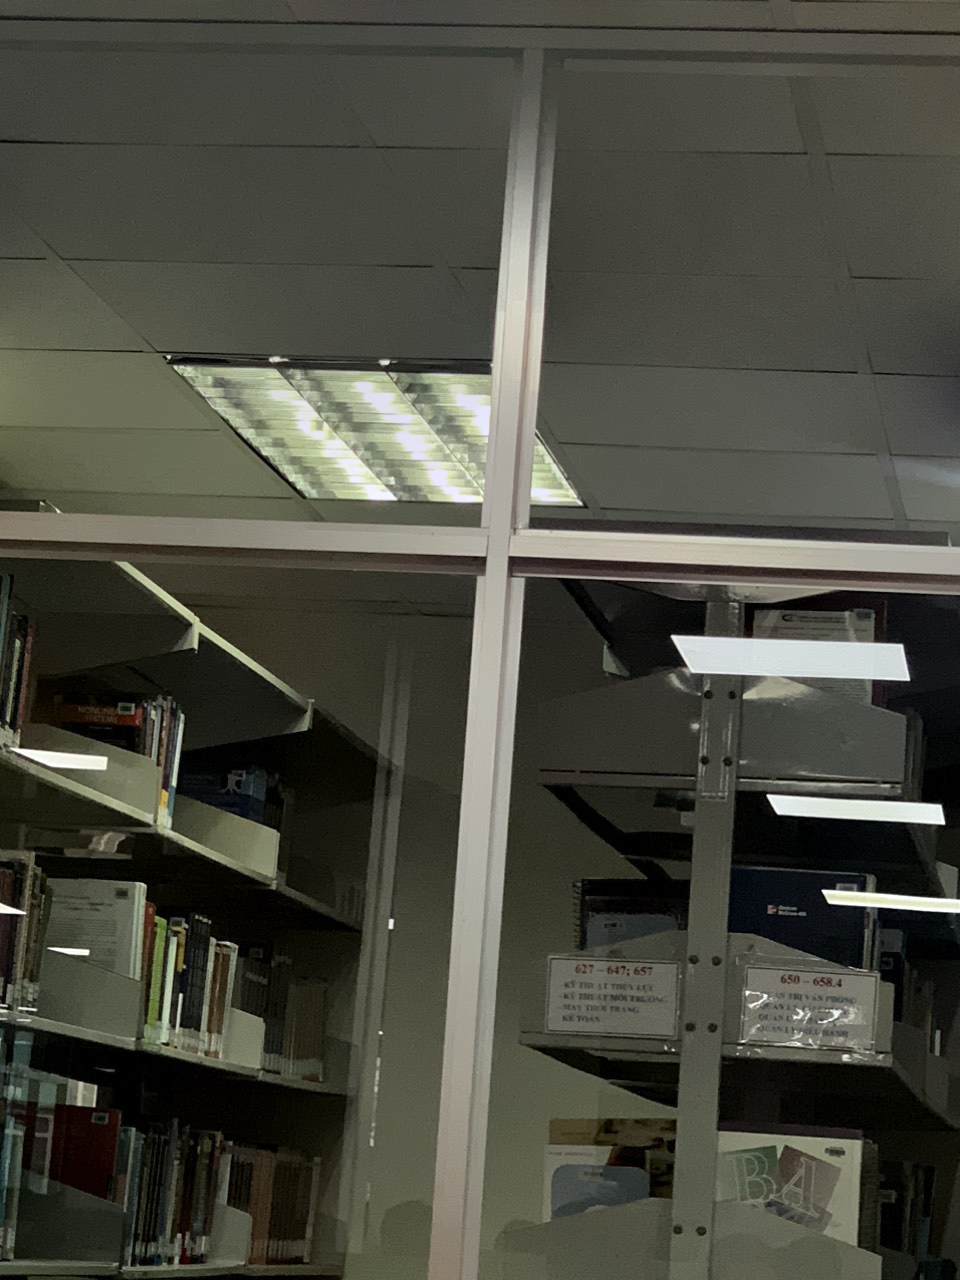

In [226]:
img = Image.fromarray(np.uint8(LB_upsize*255))

# Enhance Brightness
curr_bri = ImageEnhance.Brightness(img)
new_bri = 1.2
  
# Brightness enhanced by a factor of 2.5
img_brightened = curr_bri.enhance(new_bri)
  
# shows updated image in image viewer
img_brightened

2. Tweak the hyper parameters of LB14 such that we run fewer iterations or relax convergence criterion

In [227]:
LB, LR = SIRR(I,10,5,10)

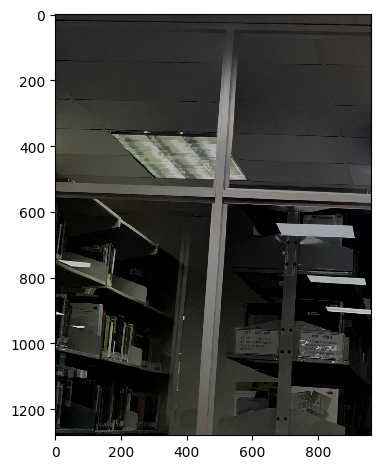

In [228]:
io.imshow(LB)

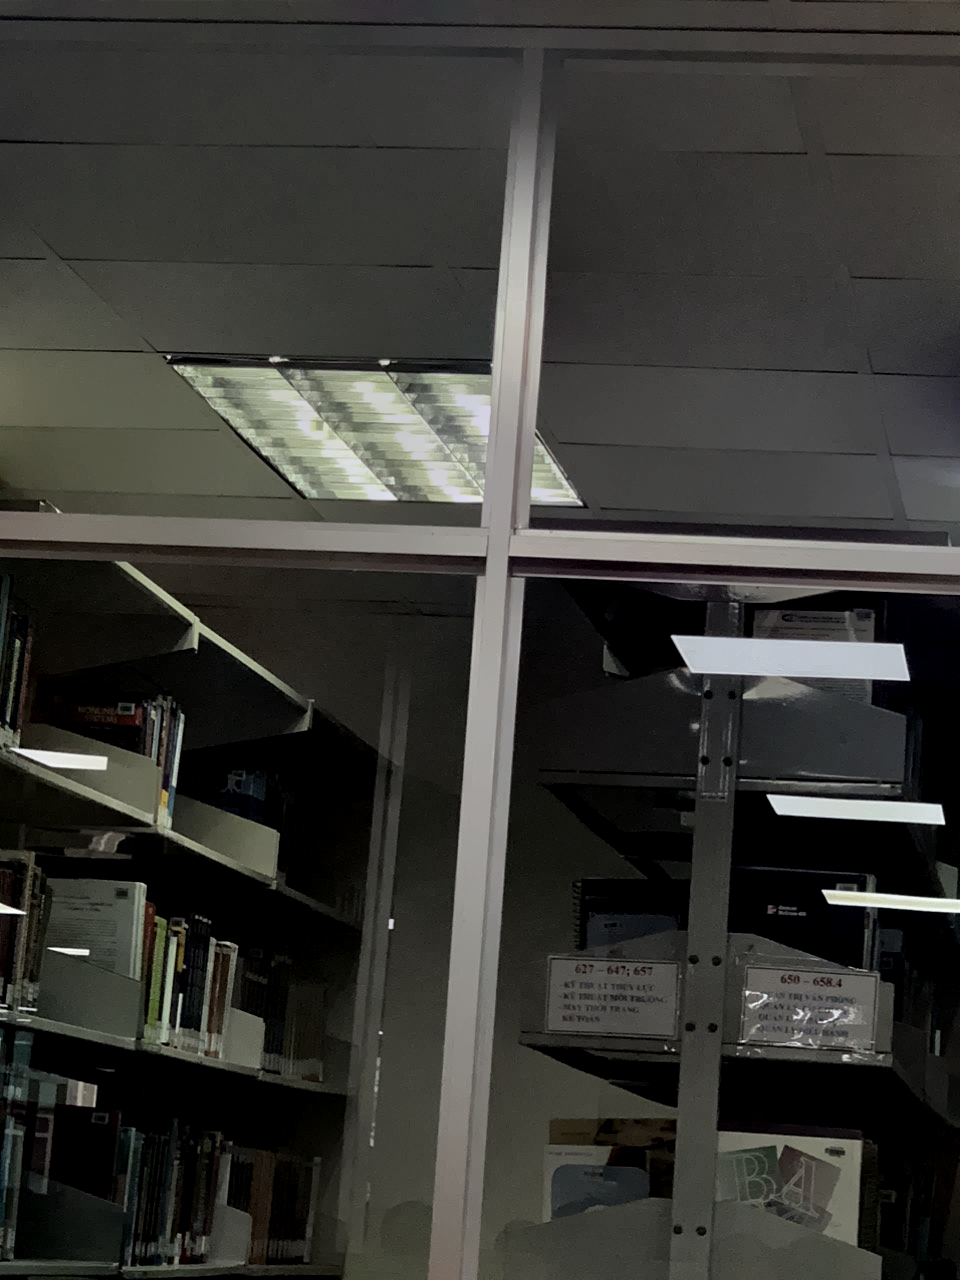

In [229]:
img = Image.fromarray(np.uint8(LB*255))

# Enhance Brightness
curr_bri = ImageEnhance.Brightness(img)
new_bri = 1.2
  
# Brightness enhanced by a factor of 2.5
img_brightened = curr_bri.enhance(new_bri)
  
# shows updated image in image viewer
img_brightened

3.  Run LB14 on the downsized version of full-res image, detect image regions with large reflections, and then run LB14 on selected crops of full-res image.